Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Pasit Tiwawongrut"
ID = "122442"

---

# Lab 12: Gaussian Mixture Models (GMMs)

Today we continue with unsupervised learning. One model that's more sophisticated than $k$-means is the Gaussian Mixture Model (GMM).

The GMM models a dataset $(\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(m)})$ as an i.i.d. sample from the following
generative model for each sample
$\mathbf{x}^{(i)}$:

1. Sample $z^{(i)}$ from a multinomial distribution over clusters $1..k$ according to probabilities $(\phi_1,\ldots,\phi_k)$.
2. Sample $\mathbf{x}^{(i)}$ from ${\cal N}(\mathbf{\mu}_{z^{(i)}},\Sigma_{z^{(i)}})$.

The parameters are estimated using the Expectation Maximization (EM) algorithm, which begins with a guess for parameters
$\phi_1,\ldots,\phi_k,\mu_1,\ldots,\mu_k,\Sigma_1,\ldots,\Sigma_k$ then iteratively alternates between computing a soft assignment
of data to clusters then updating the parameters according to that soft assignment.

First, we'll build a GMM model for a dataset then use the model for anomaly detection.

## Example 1: Anomaly detection

Let's generate synthetic data from a mixture of Gaussians, use EM to recover as best possible the ground truth parameters, and
then use the model to find "anomalies" (unusually unlikely points according to the model). First, we set up the ground truth
parameters and generate a dataset from those ground truth parameters:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Ground truth means and covariances for the data we'll generate

means_gt = [ [1,10], [10,1], [10,10] ]
sigmas_gt = [ np.matrix([[1, 0],[0, 1]]), np.matrix([[4,0],[0,1]]),
              np.matrix([[1,0],[0,4]]) ]

# Ground truth Prior probability (phi_j) for each cluster

phi_gt = [ 0.2, 0.2, 0.6 ]

# For more interesting covariances, you can also try, for example,
# [[11.31371, -0.70711],[11.31371, 0.70711]] or
# [[11.31371, 0.70711],[-11.31371, 0.70711]].

# Size of dataset

m = 500

# number of variables

n = len(means_gt[0])

# k number of clusters/outcomes

k = len(phi_gt)

# Ground truth indices of cluster identities

Z = [0]*m

# Generate a new k-means dataset

def gen_dataset():
    X = np.zeros((m,n))
    # Generate m samples from multinomial distribution using phi_gt
    z_vectors = np.random.multinomial(1, phi_gt, size=m)  # Result: binary matrix of size (m x k)
    for i in range(m):
        # Convert one-hot representation z_vectors[i,:] to an index
        Z[i] = np.where(z_vectors[i,:] == 1)[0][0]
        # Grab ground truth mean mu_{z^i}
        mu = means_gt[Z[i]]                
        # Grab ground truth covariance Sigma_{z^i}
        sigma = sigmas_gt[Z[i]]
        # Sample a 2D point from mu, sigma
        X[i,:] = np.random.multivariate_normal(mu,sigma,1)
    return X


X = gen_dataset()

Next, the EM algorithm itself. We have an initialization step and an iterative step.

In [3]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k      
        # Ramdomly assign mean to one of the data points       
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)    
    return Phi, Mu, Sigma


def Gaussian(X, mean, covariance):
    k = len(mean)
    X = X - mean.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(covariance) * X, axis=1))
    return p

def gaussian(x, mean,covariance):
    k = len(mean)
    X = (x - mean).reshape(-1,1)
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * (X.T @ np.linalg.pinv(covariance) @ X))
    return p


# Run one iteration of EM

def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        pj = Gaussian(X, Mu[:,j], Sigma[j])
        pj_arr[:,j] = pj
        W[:,j] = Phi[j] * pj
    
    # W tells us what is the relative weight of each cluster for each data point
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(2,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False

    labels = np.argmax(pj_arr, axis = 1)
    pj = np.max(pj_arr,axis=1)
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label

Let's run the model to convergence:

In [4]:
threshold = np.matrix(.01)

Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [5]:
print(Phi)
print(phi_gt)

phi_gt = np.array(phi_gt).reshape(-1,1)
phi_mse = np.mean(np.min((Phi-phi_gt)**2,axis=1))

print(phi_mse)

[0.56966113 0.21433889 0.21599998]
[0.2, 0.2, 0.6]
0.00044388476811307057


In [6]:
print(Mu)
print(np.array(means_gt).T)

[[ 9.94877065 10.10086701  1.0137263 ]
 [10.05767208  1.04842696 10.05442296]]
[[ 1 10 10]
 [10  1 10]]


In [7]:
print(Sigma)
print(sigmas_gt)

[[[ 1.18278937  0.10327419]
  [ 0.10327419  3.64484266]]

 [[ 2.63000273 -0.12175686]
  [-0.12175686  1.25839427]]

 [[ 0.97292574 -0.08707578]
  [-0.08707578  0.95187056]]]
[matrix([[1, 0],
        [0, 1]]), matrix([[4, 0],
        [0, 1]]), matrix([[1, 0],
        [0, 4]])]


### In-class exercise (not graded, for practice)

Determine how close the estimated parmeters Phi, Mu, and Sigma are to the ground trouth values set up at the beginning of the experiment. Report your results and briefly discuss here.

Next, we continue to find outliers:

In [8]:
outlier_prob = .01
outliers = np.nonzero(pj < outlier_prob)[0]

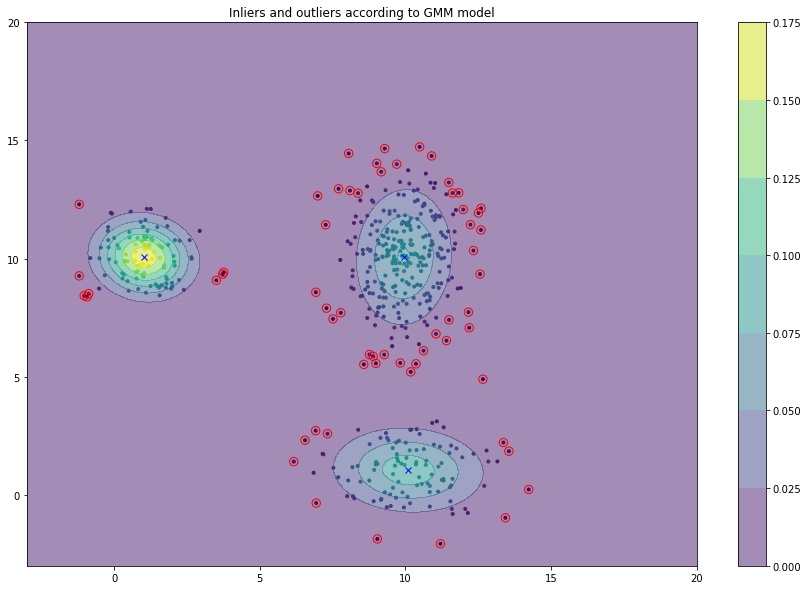

In [9]:
fig1 = plt.figure(figsize=(15,10))

xlist = np.linspace(-3, 20, 100)
ylist = np.linspace(-3, 20, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    ZZ = np.maximum(ZZ,Z)
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
cbar = fig1.colorbar(cp)

plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.title('Inliers and outliers according to GMM model')
plt.show()

### In-class exercise

Notice that using a hard threshold for each cluster gives us more outliers for a broad cluster than a
tight cluster. First, you'll want to understand why and explain.  Next, you'll read about
Mahalanobis distance
of a point to the mean of a multivariate Gaussian distribution and see if you can use Mahalanobis distance
to get a better notion of outliers in this dataset.

### Exercise 1.1 (10 points)

Notice that using a hard threshold for each cluster gives us more outliers for a broad cluster than a tight cluster. Understand why, and explain here.

In tight cluster most data tend to have high propability in the border because of low variance, while in broad cluster have more variance meaning boder data will have
low propability. So by using hard threshold broad cluster will have more outlier because border data have low propability.

### Exercise 1.2 (15 points)

Read about Mahalanobis distance of a point to the mean of a multivariate Gaussian distribution and see if you can use Mahalanobis distance to get a better notion of outliers in this dataset.
1. Explain what is Mahalanobis (5 points)
2. Write code Mahalanobis (10 points)

#### Explain what is Mahalanobis distance (5 points)

Mahalanobis is another distancing method for data with correlation. The data that have more correlation will have shorter distance.

#### Write code to compute Mahalanobis distance between the data and their nearest means (10 points)

In [10]:
import sys
#np.set_printoptions(threshold=sys.maxsize)

print(Sigma.shape)
print(Mu.shape)
print(X.shape)

m_distance = np.zeros((X.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X):
        # get all row data from target column
        mu = Mu[:, kk]
        # get target sigma
        sig = Sigma[kk, :]
        # inverse matrix of sigma
        sig_inv = sig.T
        # find difference of mu and x and reshape it (if need)
        diff = x - mu
        # calculate distance from diff and sigma
        distance = diff.T @ np.linalg.inv(sig_inv) @ diff
        # keep distance
        m_distance[i,kk] = distance

print()
# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin
(unique, counts) = np.unique(np.argmin(m_distance, axis=1), return_counts=True)

max_z_score = 2.05
# find minimum distance
# hint: use np.min
min_distance = np.min(m_distance, axis=1)
# find outlier from min_distance
outlier = min_distance > max_z_score

(3, 2, 2)
(2, 3)
(500, 2)



outlier [ True  True  True False  True False False False False  True  True False
 False False  True  True False False False  True False False False False
 False  True False False False False False False  True False  True False
 False False False False False False  True  True False  True  True False
  True  True  True  True False  True False False False False  True  True
 False False  True  True False  True False False False  True  True False
 False False False False  True  True  True  True False False False False
 False False False False False  True False  True False False  True False
 False False False False False False False False False  True False  True
 False False False  True False  True  True  True False  True False False
  True False  True  True False False False  True False False  True  True
  True False False False False False  True False False  True False  True
 False  True  True False  True False  True  True False False False  True
 False False False False  True False False 

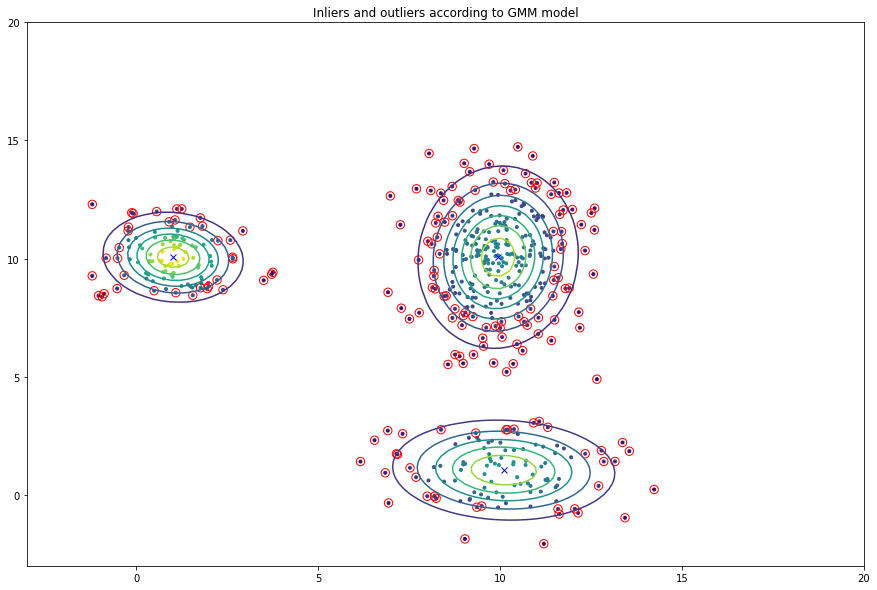

success!


In [11]:
# Test function: Do not remove
print('outlier', outlier)

fig1 = plt.figure(figsize=(15,10))

xlist = np.linspace(-3, 20, 100)
ylist = np.linspace(-3, 20, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX,YY,Z)

plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.title('Inliers and outliers according to GMM model')
plt.show()
print('success!')
# End test function

## Example 2: Customer segmentation

In this example we will use the Kaggle customer segmentation dataset
from last week. We've included the
[Mall_Customers.csv](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)
file with this lab.

Let's stick to just two dimensions in the dataset:

In [12]:
data = pd.read_csv('Mall_Customers.csv')
data = data.drop(['CustomerID', 'Gender', 'Age'], axis = 1)
print(data.head())

   Annual Income (k$)  Spending Score (1-100)
0                  15                      39
1                  15                      81
2                  16                       6
3                  16                      77
4                  17                      40


In [13]:
X  = np.array(data, dtype=float)

n = X.shape[1]
m = X.shape[0]
k = 3

threshold = np.matrix(.01)

# Slightly different version of init_gmm due to the data format and spread
def init_gmm(X, k):
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        Phi[j] = 1/k
        Mu[:,j] = X[order[j],:].T
        Sigma[j,:,:] = np.cov(X.T)
    return Phi, Mu, Sigma


Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [14]:
print(Mu)

[[48.76128239 60.96534549 89.81455141]
 [56.2600988  55.94848014 14.96258356]]


The first row represents annual income, whereas the second row represents the spending score. These values tend to change in every iteration, so therefore it is difficult to definitively segregate the data into three categories.

In [15]:
print(Sigma.shape)
print(Mu.shape)

(3, 2, 2)
(2, 3)


Next, the visualization:

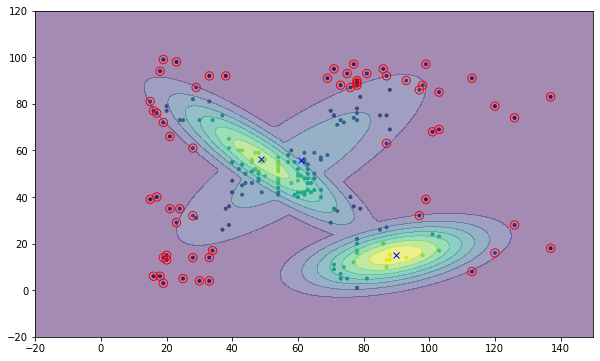

In [16]:
plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

outlier_prob = .0002
outliers = np.nonzero(pj<outlier_prob)[0]


xlist = np.linspace(-20, 150, 100)
ylist = np.linspace(-20, 120, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)
for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1    
    ZZ = np.maximum(ZZ,Z)
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.show()

### In-class exercise (25 points)

Examine the cluster centers and determine whether you can find any reasonable interpretation of them.
Discuss in your report (5 points), and compare to the $k$-means method from last week. (20 points)

#### Interpretation of clusters (5 points)

YOUR ANSWER HERE

#### Run $k$-means and compare results

running k-means on cpu..


[running kmeans]: 5it [00:00, 174.47it/s, center_shift=0.000000, iteration=5, tol=0.000100]


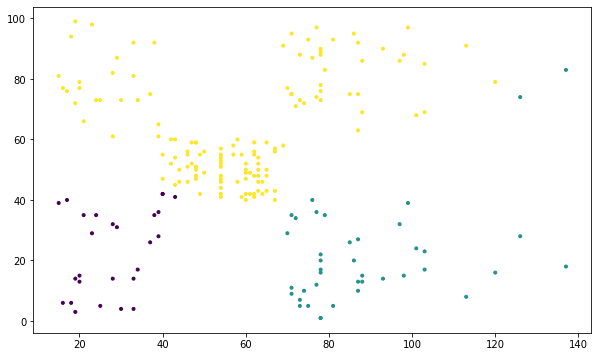

In [18]:
import torch
from kmeans_pytorch import kmeans

x = torch.from_numpy(X)
device = 'cuda:0'
device = 'cpu'
c, means = kmeans(X=x, num_clusters=3, distance='euclidean', device=torch.device(device))

plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=c,cmap='viridis')

In [19]:
m_distance = np.zeros((X.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X):
        mu = Mu[:, kk]
        sig = Sigma[kk, :]
        sig_inv = sig.T
        diff = x - mu
        distance = diff.T @ np.linalg.inv(sig_inv) @ diff
        m_distance[i,kk] = distance

print()
(unique, counts) = np.unique(np.argmin(m_distance, axis=1), return_counts=True)

max_z_score = 2.05
min_distance = np.min(m_distance, axis=1)
outlier = min_distance > max_z_score

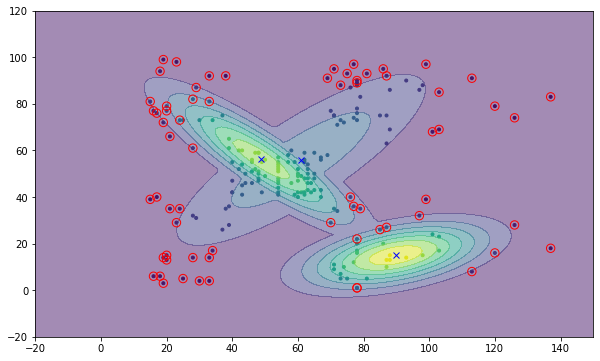

In [20]:
plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

xlist = np.linspace(-20, 150, 100)
ylist = np.linspace(-20, 120, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)
for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1    
    ZZ = np.maximum(ZZ,Z)
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.show()

### In-class exercise (10 points)

Do the same analysis with Mahalanobis distance as in the first example.

In [ ]:
outlier = None

In [ ]:
# Test function: Do not remove
print('outlier', outlier)

plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    xlist = np.linspace(0, 150, 50)
    ylist = np.linspace(0, 120, 50)
    
    XX, YY = np.meshgrid(xlist, ylist)
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX, YY, Z)

plt.show()
print('success!')
# End test function

### Example 3: Customer segmentation

This example is based on [Nguyen Hanh's tutorial on Medium.com](https://medium.com/@nguyenbaha/buiding-customer-segmentation-by-gmm-from-scratch-4ea6adc3da1c). In this example we use the Kaggle [OnlineRetail.csv](https://www.kaggle.com/vijayuv/onlineretail) dataset for customer segmentation. 

In [ ]:
data = pd.read_csv('Online_Retail.csv')
data = data.iloc[0:5000,:]
print(data.head())
data = data.drop(['InvoiceNo','Description', 'CustomerID'], axis = 1)

Let's view the categorical and numeric columns:

In [ ]:
categorical_colmns = data.select_dtypes(include=['object']).columns
print(categorical_colmns)
numerical_colmns = data._get_numeric_data().columns
print(numerical_colmns)

In [ ]:
def missing_percentage(data):
    """This function takes a DataFrame(df) as input and returns two columns, 
     total missing values and total missing values percentage"""
    total = data.isnull().sum().sort_values(ascending = False)
    percent = round(data.isnull().sum().sort_values(ascending = False)/len(data)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])


missing_percentage(data)



Next, let's fill the "na" values with "No information" and 0

In [ ]:
data[categorical_colmns] = data[categorical_colmns].fillna("No information")
data[numerical_colmns] = data[numerical_colmns].fillna(0)

print(data.head())

Now let's convert the categorical columns to numeric. Give some thought as to whether it's appropriate
to do so for all of the columns.

In [ ]:
def category_to_numeric(categorical_columns):
    i = 0;
    columnname = '';
    while i < len(categorical_colmns):
        col_idx = data.columns.get_loc(categorical_colmns[i])
        distinct_values = data[categorical_colmns[i]].unique()
        j = 0;    
        for val in distinct_values:
            idx = np.where(data[categorical_colmns[i]] == val);
            data.iloc[idx[0],col_idx] = j            
            j = j + 1;
        i = i + 1;
        
        
category_to_numeric(data[categorical_colmns])

data = data.astype('float64')
print(data.head())

In [ ]:
Mu = np.mean(data[numerical_colmns])
Sigma = np.std(data[numerical_colmns])
print(Mu)
print(Sigma)

In [ ]:
# Check for outliers

def cnt_outlier(data, sigma, mu, inc_cols=[]):
    num_cols = data.select_dtypes(include=[np.number]).columns
    num_cols = [e for e in num_cols if e in inc_cols]
    outlier = (data[numerical_colmns]-mu).abs() > sigma*3
    return outlier.sum()

cnt_outlier(data, Sigma, Mu, numerical_colmns).sort_values(ascending=False)

In [ ]:
if len(data[data.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(data[data.duplicated()]))
    print(data[data.duplicated(keep=False)].sort_values(by=list(data.columns)).head())
    data.drop_duplicates(inplace=True)
else:
    print("No duplicated entries found")

## In-class and take-home exercise

Use the same GMM code as in the previous two examples on this dataset. Try to interepret the
results you get and plot the inliers/outliers with a Mahalanobis distance
threshold. Plot likelihood as a function of $k$ and determine whether there is an "elbow"
in the plot. How many clusters should you use? Describe your experiments and results in your report.

In [ ]:
X = data.values

mean = np.mean(X,axis=0)
std = np.std(X,axis=0)

X = (X-mean)/std

print(X)

In [ ]:
# Your code here